In [34]:
# Classification with CNN
# Fashion MNist

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
import tensorflow_datasets as tfds
import pandas as pd
import seaborn as sns

In [39]:
f_mnist = tf.keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = f_mnist.load_data()

print(X_train.shape)
print(X_test.shape)




(60000, 28, 28)
(10000, 28, 28)


In [40]:
# this is 2D array (but CNN needs 3D array)
# CNN needs height x and width x color
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print(X_train.shape)
print(X_test.shape)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [41]:
# k = len(np.unique(Y_train))
k = len(set(Y_train))
print("number of classes:", k)

print("shape: ",X_train[0].shape)

number of classes: 10
shape:  (28, 28, 1)


In [42]:
#------- Augmentation ---------
from tensorflow.keras import layers # import layers instead of preprocessing

# Define the augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2), #use layers.RandomRotation
    layers.RandomZoom(0.2), #use layers.RandomZoom
    layers.RandomFlip('horizontal'), #use layers.RandomFlip
    layers.RandomTranslation(0.2, 0.2) #use layers.RandomTranslation
])

# Apply augmentation
augmented_X_train = data_augmentation(X_train)

# for augmented_image in augmented_train_data:
#     plt.imshow(augmented_image, cmap="gray")
#     plt.show()

#---- end ------


# Build the model using functional API
i = Input(shape=X_train[0].shape)
x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(k, activation='softmax')(x)


from tensorflow.keras import regularizers
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x) # Add the new Dense layer with regularization here
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

model.compile(
                 optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy']
             )

# Optimize Learning Rate
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Reduce learning rate if validation loss doesn't improve
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train with Callbacks
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

r = model.fit(augmented_X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, callbacks=[early_stop, lr_scheduler])


Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.3646 - loss: 1.9792 - val_accuracy: 0.5882 - val_loss: 1.3900 - learning_rate: 0.0010
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.5752 - loss: 1.2311 - val_accuracy: 0.5943 - val_loss: 1.2000 - learning_rate: 0.0010
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6271 - loss: 1.0598 - val_accuracy: 0.6130 - val_loss: 1.3858 - learning_rate: 0.0010
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6583 - loss: 0.9635 - val_accuracy: 0.6416 - val_loss: 1.2743 - learning_rate: 0.0010
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6736 - loss: 0.9015 - val_accuracy: 0.6392 - val_loss: 1.2716 - learning_rate: 0.0010
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7074 - loss: 0.8007 - val_accuracy: 0.6186 - val_loss: 1.4050 - learning_rate: 5.0000e-04
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 

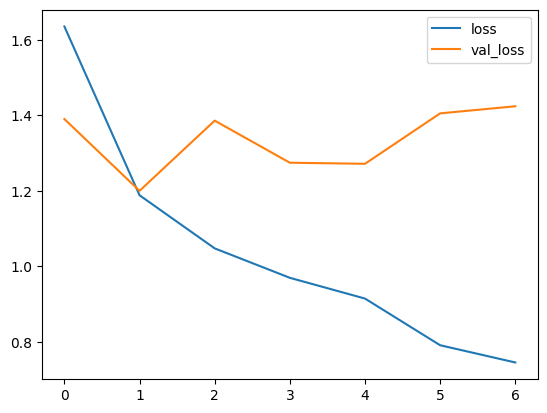

In [43]:
# plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()


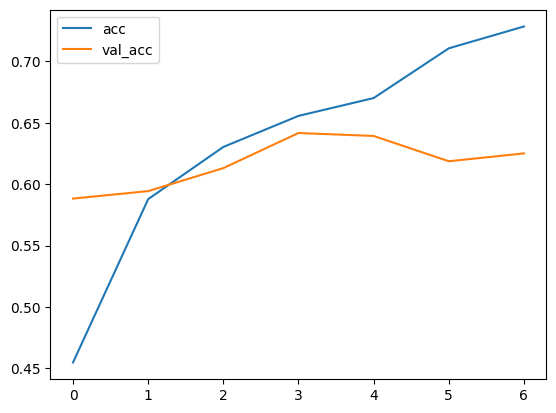

In [44]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [45]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(Y_test, Y_pred_classes)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


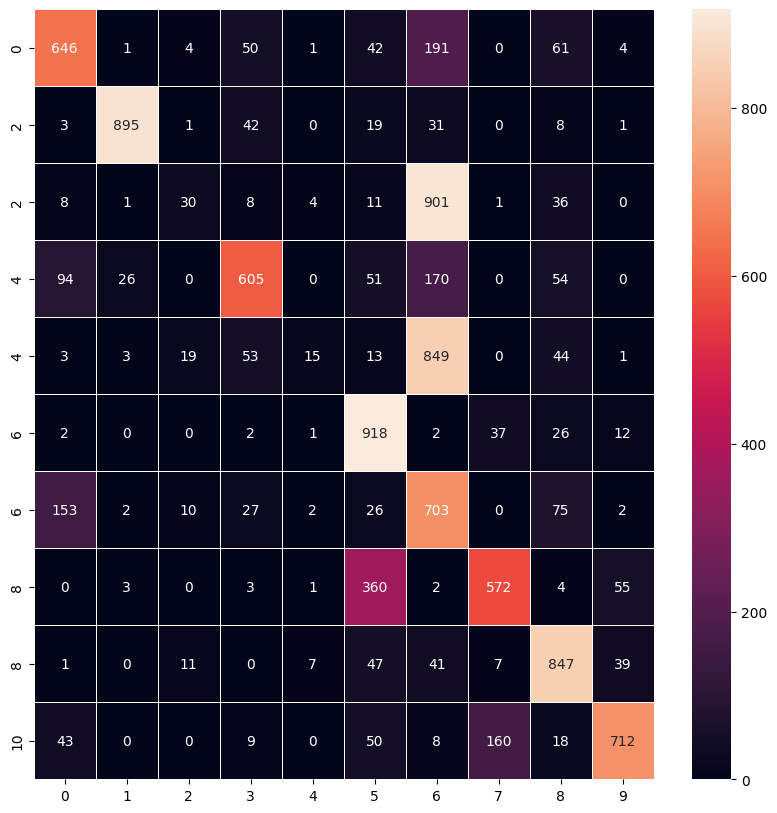

In [46]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots(figsize=(10, 10))  # Set the figure size
sns.heatmap(cm, annot=True, linewidths=0.5, fmt="d", ax=ax) #fmt="d" to display the values in the heatmap as integers
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
plt.draw()
plt.show()




In [47]:
# pip install --upgrade scikit-learn

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()



313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion matrix, without normalization
[[646   1   4  50   1  42 191   0  61   4]
 [  3 895   1  42   0  19  31   0   8   1]
 [  8   1  30   8   4  11 901   1  36   0]
 [ 94  26   0 605   0  51 170   0  54   0]
 [  3   3  19  53  15  13 849   0  44   1]
 [  2   0   0   2   1 918   2  37  26  12]
 [153   2  10  27   2  26 703   0  75   2]
 [  0   3   0   3   1 360   2 572   4  55]
 [  1   0  11   0   7  47  41   7 847  39]
 [ 43   0   0   9   0  50   8 160  18 712]]


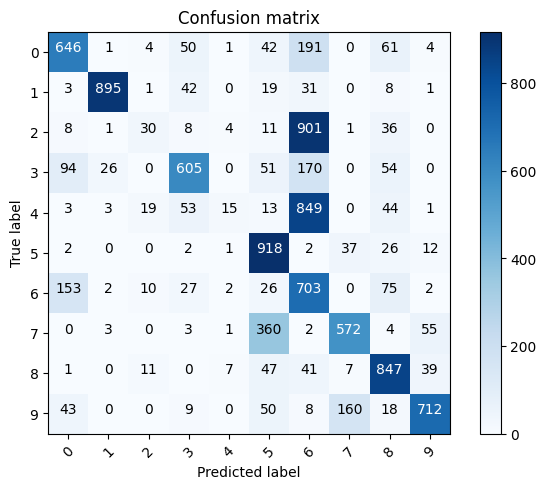

In [48]:
#predict
p_test = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(Y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))


all labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
60000


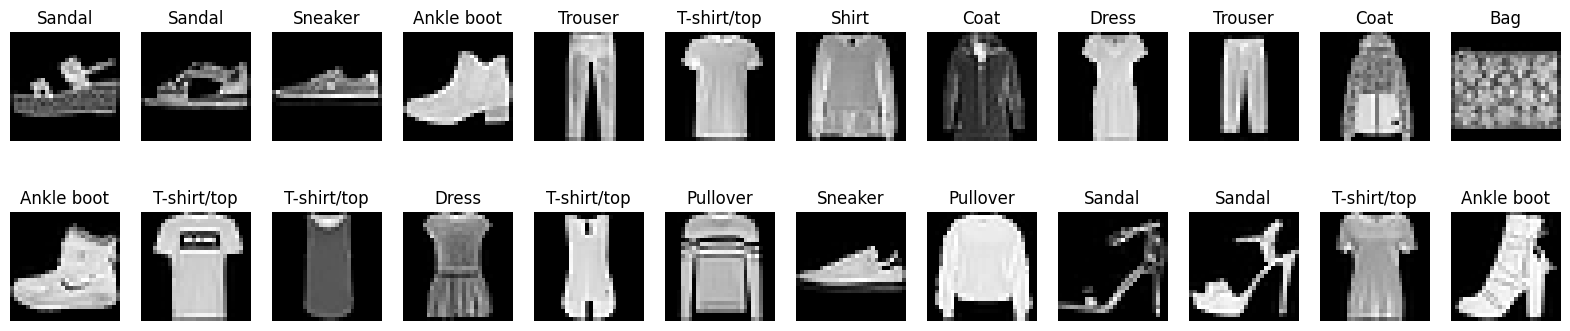

In [49]:
# Label mapping
# labels = '''T-shirts/top
# Trouser
# Pullover
# Dress
# Coat
# Sandal
# Boot
# Shirt'''.split()

# print(labels)

import torchvision.datasets as datasets
fashion_mnist = datasets.FashionMNIST(root='data', download=True)
labels = fashion_mnist.classes

print("all labels:", labels)
print(len(X_train))

import matplotlib.pyplot as plt


plt.figure(figsize=(20, 7))

row = 1
col = 1
idx = 1

for i in range(24):
    plt.subplot(row, 12, idx)

    plt.imshow(X_train[i], cmap='gray')
    plt.title(labels[Y_train[i]])
    plt.axis('off')

    # print(row,idx)

    if(idx == 12):
        row += 1
        idx = 1
        # print(row, idx)
    else:
        idx += 1

plt.subplots_adjust(hspace=1.0)
plt.show()



misclassified examples count:  4057


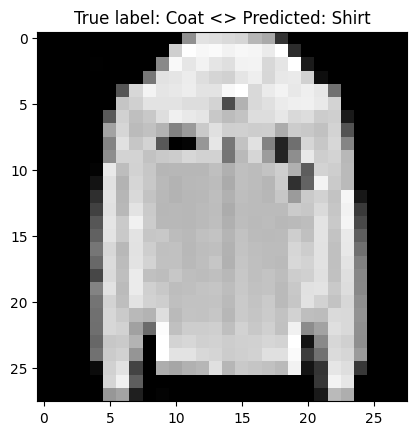

In [50]:
# show some misclassified example
misclassified_idx = np.where(p_test != Y_test)[0]
print("misclassified examples count: ", len(misclassified_idx))
i = np.random.choice(misclassified_idx)
plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
plt.title("True label: %s <> Predicted: %s" % (labels[Y_test[i]], labels[p_test[i]]));


correct classified examples count:  5943


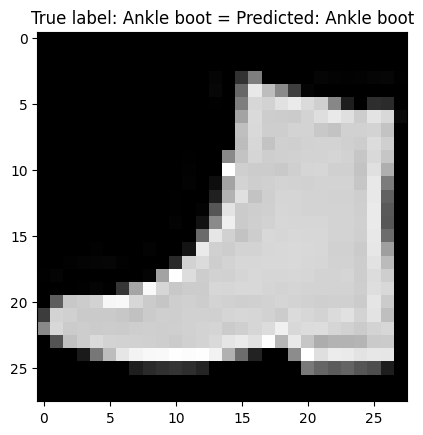

In [51]:
# show some correct classified example
ok  = np.where(p_test == Y_test)
not_ok  = np.where(p_test != Y_test)

corrclassified_idx = np.where(p_test == Y_test)[0]
print("correct classified examples count: ", len(corrclassified_idx))
i = np.random.choice(corrclassified_idx)
plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
plt.title("True label: %s = Predicted: %s" % (labels[Y_test[i]], labels[p_test[i]]));


In [52]:
model.save('model_optimizedWithAug.keras')
model.down